# Project P3

`Auteur` : Romain Capocasale (INF2dlm-a)

`Date` : 01.10.2019

`Version de python` : 3.7.1

# Importation

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, TransformerMixin
from spacy.lang.en.stop_words import STOP_WORDS

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import spacy

# Chragement du jeu de données

In [2]:
dataset = pd.read_json('dataset/financialData.json')

# Analyse du jeu de données

In [3]:
dataset.head()

,sentiment,title
0,0.366,watching for bounce tomorrow
1,0.638,record number of passengers served in 2015
2,-0.494,out $NFLX -.35
3,0.460,Looking for a strong bounce Lunchtime rally co...
4,0.403,Very intrigued with the technology and growth ...


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2866 entries, 0 to 2865
Data columns (total 2 columns):
sentiment    2866 non-null float64
title        2866 non-null object
dtypes: float64(1), object(1)
memory usage: 44.9+ KB


In [5]:
dataset.describe()

,sentiment
count,2866.000000
mean,0.079841
std,0.391033
min,-1.000000
25%,-0.285000
50%,0.206000
75%,0.387000
max,1.000000


Le jeu de données contient 2 colonnes :
    - sentiment : le sentiment de la pharse, -1 pour positif et 1 pour positif
    - title : la phrase en question

# Répartition des classes

In [6]:
nb_pos, nb_neg, nb_ntr = len([sent for sent in dataset.sentiment if sent > 0]), len([sent for sent in dataset.sentiment if sent < 0]), len([sent for sent in dataset.sentiment if sent == 0])
tot = len(dataset)
print("Number of data : {}".format(tot))
print("Number of positive data : {} ({}%)".format(nb_pos, round( nb_pos/tot*100, 3)))
print("Number of negative data : {} ({}%)".format(nb_neg, round( nb_neg/tot*100, 3)))
print("Number of neutral data : {} ({}%)".format(nb_ntr, round( nb_ntr/tot*100, 3)))
print("Ratio positive/negative : {}".format(round(nb_pos/nb_neg, 3)))

Number of data : 2866
Number of positive data : 1756 (61.27%)
Number of negative data : 1045 (36.462%)
Number of neutral data : 65 (2.268%)
Ratio positive/negative : 1.68


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001612B38C748>]],
      dtype=object)

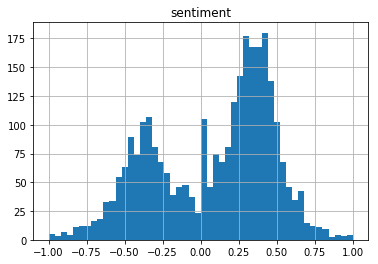

In [7]:
dataset.hist(bins=50)

On remarque qu'il y a beaucoup plus de phrase avec un sentiment positif que négatif. On remarque égalemne sur le graphe 2 pics, un pour les sentiments négatifs aux alentours de -0.40 et un pour les sentiment négatifs

# Nombre de mot moyen par phrase

In [8]:
def average_word_by_sentence(sentences):
    nb_total_word = 0
    for row in sentences:
        nb_total_word += len(row.split())
    return round(nb_total_word / len(sentences), 3)

In [9]:
print("Average of word by sentence : {}".format(average_word_by_sentence(dataset['title'])) )

Average of word by sentence : 7.515


Text(0, 0.5, 'Number of sentence')

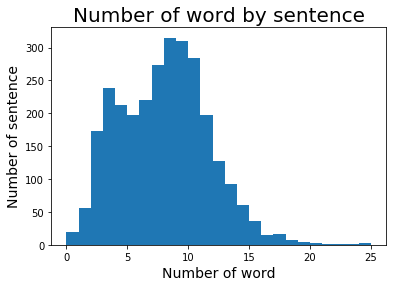

In [10]:
num_word_by_sentence = [len(x.split()) for x in dataset['title']]#count the number of word for each sentences

plt.hist(num_word_by_sentence, bins=25)
plt.title('Number of word by sentence', fontsize=20)
plt.xlabel('Number of word', fontsize=14)
plt.ylabel('Number of sentence', fontsize=14)

On remarque que la moyenne de nombre de mot par phrase est de **7.515** et on peut voir sur le graphe la répartirion du nombre de mot par phrase.

# Récupération des valeurs x et y

In [11]:
X = dataset['title']
y = dataset['sentiment']

# Séparation du jeu d'entrainement et jeu de test 
Je n'utilise pas la classe StratifiedShuffleSplit qui assure une répartition équitable entre le nombre de phrase positive et négative dans le jeu de test et le jeu d'entrainement car étant donné qu'il y a beaucoup plus de phrase positive que négative on perderait une grande partie du jeu de donnée.
Le jeu d'entrainement est séparé en 2 parties, La première partie est le jeu d'entrainement qui sera utilisé pour la création du modèle d'analyse de sentiment. Le jeu de test sera lui utilisé pour tester la qualité des modèles évalués.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Score de textblob et VADER
Nous allons comparé le score de l'analyseur de sentiment de VADER(nltk) et textblob sur le jeu d'entrainement. Il est à noté que les phrases ne sont pas prétraité avant d'être envoyé aux analyseur de sentiment. En effet, ces 2 analyseur posséde leur propre méthode de prétraitement de texte. Les scores obtenus ici seront utilisé comme score de référence pour l'évaluation des futures modèles.
La métrique utilisé pour l'évaluation est la RMSE (Root Mean Square Error). Elle permet de donner une idée des erreurs de prédiction commise par le système. Cette métrique correspond à la norme euclidienne.

In [13]:
y_pred_textblob = []

for x in X_test:
    blob_analyser = TextBlob(x)
    y_pred_textblob.append(blob_analyser.polarity)
    
y_pred_textblob = np.array(y_pred_textblob)
print("RMSE for textblob : {}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_textblob))))
print("MAE for textblob : {}".format(metrics.mean_absolute_error(y_test, y_pred_textblob)))

RMSE for textblob : 0.3946489568269569
MAE for textblob : 0.3349477944641503


In [14]:
vader_analyser = SentimentIntensityAnalyzer()

y_pred_vader = []
for x in X_test:
    y_pred_vader.append(vader_analyser.polarity_scores(x)['compound'])

y_pred_vader = np.array(y_pred_vader)
print("RMSE for VADER : {}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_vader))))
print("MAE for VADER : {}".format(metrics.mean_absolute_error(y_test, y_pred_vader)))

RMSE for VADER : 0.410972061994435
MAE for VADER : 0.33345084566596195


On constate que les résultats obetnus sont plutot muavais, il est alors intéressant de créer un modèle dans le but d'obtenir de meilleurs résultats.

In [26]:
nlp = spacy.load('en')
punctuations = string.punctuation
good_words = ['VERB', 'ADV', 'NOUN', 'ADJ']
min_word_size = 2

def spacy_text_preprocessing(sentence):
    final_sentence = []
    for word in nlp(sentence):
        if word.pos_ in good_words and len(word.text) > min_word_size and word.text not in punctuations:
            final_sentence.append(word.lemma_.lower())
    return final_sentence

In [16]:
index = 1002
print(f'sentence raw : {X[index]}')
print(f'sentence proccesed : {spacy_text_preprocessing(X[index])}')
print(f'sentiment : {y[index]}')

sentence raw : debt crisis entered a dangerous new phase 
sentence proccesed : ['debt', 'crisis', 'enter', 'dangerous', 'new', 'phase']
sentiment : -0.331


In [ ]:
def test(sentence, remove_stop_word=False, keep_only_good_word=True, min_word_size=2):
    final_sentence = []
    good_words = ['VERB', 'ADV', 'NOUN', 'ADJ']
    self.nlp = spacy.load('en')
    self.punctuations = string.punctuation
    for word in self.nlp(sentence):
        if remove_stop_word:
            if word.is_stop:
                continue

        if keep_only_good_word:
            if word.pos_ not in self.good_words:
                continue

        if min_word_size!=-1:
            if len(word.text) < self.min_word_size:
                continue

        if word.text not in self.punctuations:
            final_sentence.append(word.lemma_.lower())
    return 

In [29]:
class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, remove_stop_word=False, keep_only_good_word=True, min_word_size=2):
        self.remove_stop_word = remove_stop_word
        self.keep_only_good_word = keep_only_good_word
        self.min_word_size = min_word_size
        self.good_words = ['VERB', 'ADV', 'NOUN', 'ADJ']
        self.nlp = spacy.load('en')
        self.punctuations = string.punctuation
        
    def spacy_text_processing(self, sentence):
        final_sentence = []
        for word in self.nlp(sentence):
            if remove_stop_word:
                if word.is_stop:
                    continue
            
            if keep_only_good_word:
                if word.pos_ not in self.good_words:
                    continue
                    
            if min_word_size!=-1:
                if len(word.text) < self.min_word_size:
                    continue
                    
            if word.text not in self.punctuations:
                final_sentence.append(word.lemma_.lower())
        
    def transform(self, X):
        return 
    
    def fit(self, X, y=None):
        return self

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
linear_regression = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_text_preprocessing)),
                ('tfidf', TfidfTransformer()),
                ('linear_regression', LinearRegression())])

svr = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_text_preprocessing)),
                ('tfidf', TfidfTransformer()),
                ('svr', SVR(kernel='poly'))])

random_forest_regressor = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_text_preprocessing)),
                ('tfidf', TfidfTransformer()),
                ('rfr', RandomForestRegressor())])

linear_regression.fit(X_train, y_train)
random_forest_regressor.fit(X_train, y_train)
svr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...  gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

In [28]:
y_pred_linear_regression = linear_regression.predict(X_test)
print("RMSE for linear_regression : {}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear_regression))))
print("MAE for linear_regression : {}".format(metrics.mean_absolute_error(y_test, y_pred_linear_regression)))
print("\n")
y_pred_rfr = random_forest_regressor.predict(X_test)
print("RMSE for rfr : {}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfr))))
print("MAE for rfr : {}".format(metrics.mean_absolute_error(y_test, y_pred_rfr)))
print("\n")
y_pred_svr = svr.predict(X_test)
print("RMSE for svr : {}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_svr))))
print("MAE for svr : {}".format(metrics.mean_absolute_error(y_test, y_pred_svr)))

RMSE for linear_regression : 0.7361010608419413
MAE for linear_regression : 0.478932666064547


RMSE for rfr : 0.29998778600253395
MAE for rfr : 0.21620191475961106


RMSE for svr : 0.4026153740801085
MAE for svr : 0.3256469343754733


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(random_forest_regressor, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

ValueError: Invalid parameter max_features for estimator Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
tree_rmse_scores

In [ ]:
tree_rmse_scores.mean()

In [21]:
estimator.get_params().keys()

NameError: name 'estimator' is not defined

In [22]:
random_forest_regressor.get_params().keys()

dict_keys(['memory', 'steps', 'vectorizer', 'tfidf', 'rfr', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__preprocessor', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'rfr__bootstrap', 'rfr__criterion', 'rfr__max_depth', 'rfr__max_features', 'rfr__max_leaf_nodes', 'rfr__min_impurity_decrease', 'rfr__min_impurity_split', 'rfr__min_samples_leaf', 'rfr__min_samples_split', 'rfr__min_weight_fraction_leaf', 'rfr__n_estimators', 'rfr__n_jobs', 'rfr__oob_score', 'rfr__random_state', 'rfr__verbose', 'rfr__warm_start'])